In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

 # Load data

In [2]:
data = pd.read_excel("Supplementary Data 1.xlsx")
X = data.loc[:, ["qtype", "Al", "Ti", "Li", "Ge", "Sr"]]  # "Al / Li", "Al / atomic mass of Al + Li / atomic mass of Li""


In [3]:

for col_i in range(1, 6):
    X.iloc[:, col_i] = pd.to_numeric(X.iloc[:, col_i], errors="coerce")
X.dropna(inplace=True)
y = X.pop('qtype')
print(len(X))  # number of samples
print(y.value_counts()) # number of samples in each class


1690
orogenic      339
greisen       325
porphyry      272
granite       237
skarn         203
carlin        127
IRG            96
pegmatite      65
epithermal     26
Name: qtype, dtype: int64


In [4]:
# split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# samples in test set for each class
y_test.value_counts()


greisen       64
orogenic      63
porphyry      57
granite       51
skarn         39
carlin        24
IRG           20
pegmatite     14
epithermal     6
Name: qtype, dtype: int64

 # Make Pipeline

In [5]:
log_transformer = FunctionTransformer(np.log, validate=True)
pipe_clf = make_pipeline(log_transformer, StandardScaler(), SVC(cache_size=1000, probability=True))
pipe_clf


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<ufunc 'log'>, validate=True)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(cache_size=1000, probability=True))])

 # Parameter estimation using grid search with cross-validation and retrain


In [6]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [7]:
C_range = np.logspace(-2, 8, 20, base=2)
gamma_range = np.logspace(-5, 3, 20, base=2)

param_grid = {"svc__kernel": ["rbf"], "svc__gamma": gamma_range, "svc__C": C_range}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=2)

In [8]:
grid = GridSearchCV(
    pipe_clf, param_grid=param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, refit=True
)
grid.fit(X_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'svc__C': 3.2136449062675294, 'svc__gamma': 1.0371550444461919, 'svc__kernel': 'rbf'} with a score of 0.85


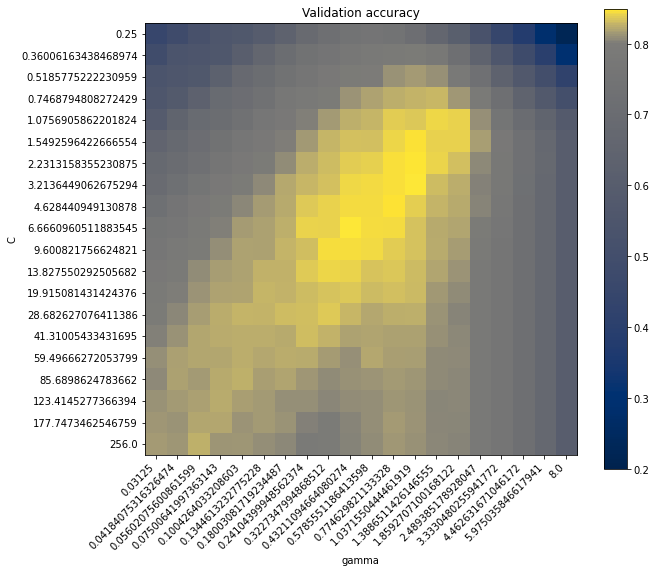

In [9]:
# Visualization
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.cividis,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.8),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45, ha="right")
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

 # Report


In [10]:
y_test_pred = grid.predict(X_test)
t_train_pred = grid.predict(X_train)

In [11]:
# train set report
print(classification_report(y_train, t_train_pred))

              precision    recall  f1-score   support

         IRG       0.92      0.93      0.93        76
      carlin       0.99      1.00      1.00       103
  epithermal       1.00      0.95      0.97        20
     granite       0.94      0.96      0.95       186
     greisen       0.92      0.94      0.93       261
    orogenic       0.97      0.94      0.96       276
   pegmatite       0.92      0.94      0.93        51
    porphyry       0.94      0.94      0.94       215
       skarn       0.94      0.91      0.92       164

    accuracy                           0.94      1352
   macro avg       0.95      0.95      0.95      1352
weighted avg       0.94      0.94      0.94      1352



In [12]:
# final evaluation
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

         IRG       0.90      0.90      0.90        20
      carlin       0.92      0.96      0.94        24
  epithermal       1.00      1.00      1.00         6
     granite       0.96      0.92      0.94        51
     greisen       0.78      0.89      0.83        64
    orogenic       0.79      0.84      0.82        63
   pegmatite       1.00      0.71      0.83        14
    porphyry       0.89      0.86      0.88        57
       skarn       0.82      0.69      0.75        39

    accuracy                           0.86       338
   macro avg       0.90      0.86      0.88       338
weighted avg       0.86      0.86      0.86       338

[[18  0  0  0  1  1  0  0  0]
 [ 0 23  0  0  0  1  0  0  0]
 [ 0  0  6  0  0  0  0  0  0]
 [ 0  0  0 47  1  3  0  0  0]
 [ 0  0  0  2 57  2  0  2  1]
 [ 0  1  0  0  6 53  0  1  2]
 [ 1  0  0  0  1  0 10  1  1]
 [ 0  0  0  0  5  1  0 49  2]
 [ 1  1  0  0  2  6  0  2 27]]


Text(0.05, 0.98, 'Fig. 5')

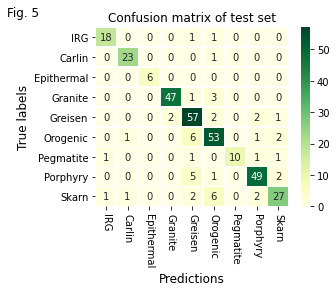

In [13]:
# heatmap the confusion matrix of test data
# ---------------------------------------------------------------------
label_order = [
    "IRG",
    "carlin",
    "epithermal",
    "granite",
    "greisen",
    "orogenic",
    "pegmatite",
    "porphyry",
    "skarn",
]
for i in range(len(label_order)):
    if label_order[i] == "IRG":
        pass
    else:
        label_order[i] = label_order[i].capitalize()
# -------------------------------------------------------------------
cm = pd.DataFrame(
    confusion_matrix(y_test, y_test_pred), columns=label_order, index=label_order
)

f, ax = plt.subplots(figsize=(4.75, 4.1))
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5, ax=ax, cmap="YlGn")
ax.set_title("Confusion matrix of test set", fontsize=12)
ax.set_xlabel("Predictions", fontsize=12)
ax.set_ylabel("True labels", fontsize=12)

plt.xticks(rotation=270)
plt.tight_layout()
f.suptitle('Fig. 5', x=0.05)
# f.savefig('./figures/confusion_matrix.png', dpi=300)
# f.savefig('./figures/confusion_matrix.pdf', dpi=150)


 # Model persistence

In [14]:
from joblib import dump
dump(grid, "quartz_clf.joblib")


['quartz_clf.joblib']